In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# 1. Đọc dữ liệu
df = pd.read_csv('/content/gdrive/MyDrive/Khóa luân 2024 (Nguyễn Tiến Anh QUân)/Dữ liệu/VCI.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.sort_values(by='Date', inplace=True)
data = df[['Closing Price']].values

In [ ]:
# 2. Chia dữ liệu thành train, validation, test
data_length = len(data)
train_size = int(data_length * 0.7)
val_size = int(data_length * 0.15)
train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

In [ ]:
# 3. Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

In [ ]:
# 4. Hàm tạo dữ liệu (X, y)
def create_dataset(data, time_steps=50):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_steps = 50
X_train, y_train = create_dataset(train_data_scaled, time_steps)
X_val, y_val = create_dataset(val_data_scaled, time_steps)
X_test, y_test = create_dataset(test_data_scaled, time_steps)

In [ ]:
# 5. Reshape dữ liệu để phù hợp với Conv1D và LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# 6. Xây dựng mô hình CNN-BiLSTM
def build_cnn_bilstm_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
    model.add(Bidirectional(LSTM(units=64)))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

cnn_bilstm_model = build_cnn_bilstm_model((X_train.shape[1], 1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# 7. Huấn luyện mô hình
cnn_bilstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 196ms/step - loss: 0.0352 - val_loss: 0.0017
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 0.0080 - val_loss: 0.0010
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - loss: 0.0060 - val_loss: 7.3435e-04
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - loss: 0.0056 - val_loss: 6.6419e-04
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - loss: 0.0044 - val_loss: 7.1516e-04
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - loss: 0.0046 - val_loss: 4.4851e-04
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - loss: 0.0039 - val_loss: 3.7472e-04
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - loss: 0.0037 - val_loss: 4.8458e-04
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - loss: 0.0031 - val_loss: 3.3808e-04
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - loss: 0.0027 - val_loss: 3.6687e-04
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 12/50
36/36 ━

In [ ]:
# 8. Dự đoán trên tập test
cnn_bilstm_pred = cnn_bilstm_model.predict(X_test)
cnn_bilstm_pred = scaler.inverse_transform(cnn_bilstm_pred)  # Chuyển về giá trị ban đầu
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step


In [ ]:
# 9. Đánh giá mô hình
print("CNN-BiLSTM Performance:")
print("MAE:", mean_absolute_error(y_test_actual, cnn_bilstm_pred))
print("MSE:", mean_squared_error(y_test_actual, cnn_bilstm_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_actual, cnn_bilstm_pred)))
print("R2 Score:", r2_score(y_test_actual, cnn_bilstm_pred))

CNN-BiLSTM Performance:
MAE: 1.4631871423488736
MSE: 3.1015286222612937
RMSE: 1.761115732216737
R2 Score: 0.7888443331189849


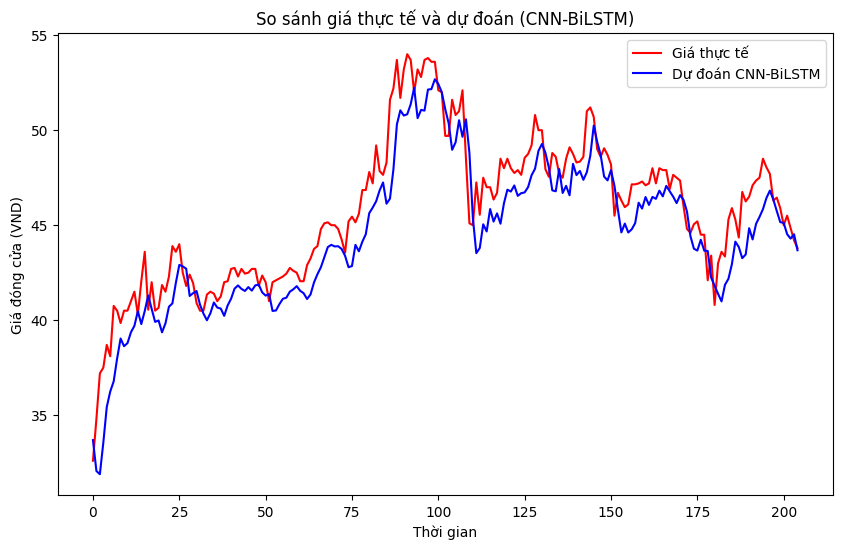

In [ ]:
# 10. Vẽ biểu đồ kết quả
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Giá thực tế', color='red')
plt.plot(cnn_bilstm_pred, label='Dự đoán CNN-BiLSTM', color='blue')
plt.title('So sánh giá thực tế và dự đoán (CNN-BiLSTM)')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VND)')
plt.legend()
plt.show()